In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib,pprint,keras

import FBNN3d,sei_kume
importlib.reload(FBNN3d)
importlib.reload(sei_kume)
from FBNN3d import *
from sei_kume import *

# FBNN3d

/home/user/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Test loss,Test mae: 23.334414, 3.616098


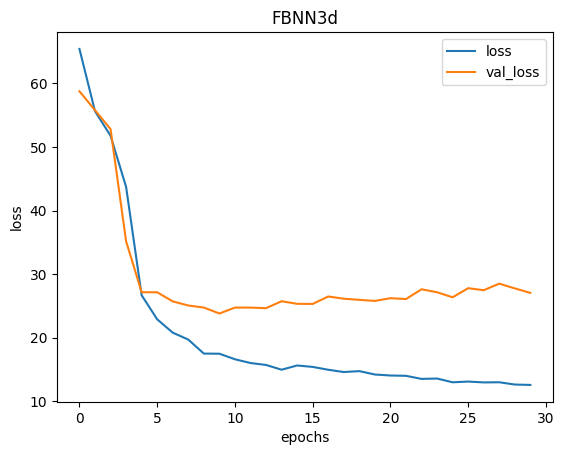

In [4]:
(x_train,y_train) = gene_data_3d(Sig_lim=20,mu_lim=20,gene_size=500,multi=100)
test_data = [gene_data_3d(Sig_lim=20,mu_lim=20,gene_size=20,multi=100) for _ in range(10)]

model = set_model_3d(n_hidden=1300,n_layer=4,print_summary=False)
history = model.fit(x_train, y_train, verbose=0, epochs=30, validation_split=0.2, shuffle=True
                    # shuffle=True, batch_size=30,validation_data=(x_test, y_test)
                    )
model.save('./models/mymodel_3d.h5')#, include_optimizer=False)

scores = [model.evaluate(x_test, y_test, verbose=0) for (x_test, y_test) in test_data]
score = np.mean(scores,axis=0)
print("Test loss,Test mae: %f, %f" %(score[0], score[1]))

fig, axes = plt.subplots()
df=pd.DataFrame(history.history)[['loss', 'val_loss']]
df.plot(ax=axes,xlabel="epochs",ylabel="loss",title="FBNN3d")
plt.show()

In [9]:
gene_size=100
print_size=int(gene_size/5)
(x_test,y_test) = gene_data_3d(Sig_lim=20,mu_lim=20,gene_size=gene_size,multi=100)

model = keras.models.load_model("./models/mymodel_3d.h5", compile=False)
res=[]
y_preds = model.predict(x_test)
for i,y_pred in enumerate(y_preds):
    pred=list(y_pred)
    Sig0 = np.array([pred[0:3],pred[1:2]+pred[3:5],pred[2:3]+pred[4:5]+pred[5:6]])
    mu0 = np.array(pred[6:])
    O0 = np.linalg.eig(Sig0)[1].T
    O0 = np.diag(np.sign(O0@Sig0@mu0))@O0
    # print(O0@Sig0@O0.T)
    th0 = np.diag(O0@Sig0@O0.T)/2
    ga0 = O0@Sig0@mu0

    y=list(y_test[i])
    Sig_T = np.array([y[0:3],y[1:2]+y[3:5],y[2:3]+y[4:5]+y[5:6]])
    mu_T = np.array(y[6:])
    O_T = np.linalg.eig(Sig_T)[1].T
    O_T = np.diag(np.sign(O_T@Sig_T@mu_T))@O_T
    # print(O_T@Sig_T@O_T.T)
    th_T = np.diag(O_T@Sig_T@O_T.T)/2
    ga_T = O_T@Sig_T@mu_T

    hist = x_test[i]
    A,B,n = AB_gene_3d(hist)

    log_0 = Loglikelihood(th0,ga0,A,B,O=O0,n=1,method="hg")
    log_T = Loglikelihood(th_T,ga_T,A,B,O=O_T,n=1,method="hg")
    # print("%2d:log_T, log_0: %f, %f"%(i+1,log_T["log"],log_0["log"]))
    res.append(abs(log_T["log"]-log_0["log"]))
    if(i%print_size==0): print(res[-1])
print("mean diff:", np.mean(res))

4/4 [==============================] - 0s 5ms/step
2.0265766551894444
3.5155118273274866
2.6720233344976236
3.0799835658830546
18.666343984250943
mean diff: 5.456079050877053


## th[0]=0

## Resnet

CNNあり/なし